# Method 2 - Best Ideas DGTW Select

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance-Adjusted Market Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data['weight'].fillna(0)) * valid_data['capm_var']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_beg_pos = p.beg_port.iloc[1:].resample('M', level=0).apply(epd.take_first)
dgtw = crsp.get_dgtw_returns(list(set(best_ideas['fsym_id'].dropna())),
                    best_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
dgtw_pivot = pd.pivot_table(dgtw, index='datadate', columns='fsym_id', values='total_return')
dgtw_cont = monthly_beg_pos.mul(dgtw_pivot, axis=1, level=0).sum(axis=1)

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - dgtw_cont).dropna()
monthly_return.name = 'port_return'

## Plot Performance

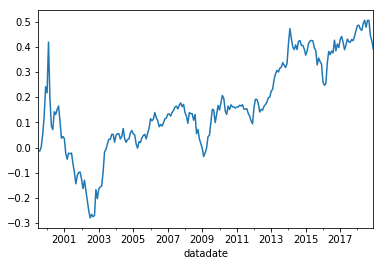

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.241414
2000-12-31   -0.159125
2001-12-31   -0.135517
2002-12-31   -0.116401
2003-12-31    0.280558
2004-12-31    0.045664
2005-12-31    0.008309
2006-12-31    0.037142
2007-12-31    0.048883
2008-12-31   -0.132949
2009-12-31    0.149065
2010-12-31   -0.008655
2011-12-31   -0.054095
2012-12-31    0.096799
2013-12-31    0.111524
2014-12-31    0.042541
2015-12-31   -0.042782
2016-12-31    0.049155
2017-12-31    0.048551
2018-12-31   -0.050376
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     66.27
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.62e-37
Time:                        01:36:14   Log-Likelihood:                 566.90
No. Observations:                 234   AIC:                            -1124.
Df Residuals:                     229   BIC:                            -1107.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      1.543      0.124      -0.001       0.005
mktrf          0.1312      0.040      3.243      0.001       0.052       0.211
me             0.2703      0.047      5.744      0.000       0.178       0.363
ia            -0.2442      0.072     -3.414      0.001      -0.385      -0.103
roe           -0.4043      0.061     -6.604      0.000      -0.525      -0.284
==============================================================================
Omnibus:                       29.784   Durbin-Watson:                   2.143
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              153.885
Skew:                           0.229   Prob(JB):                     3.84e-34
Kurtosis:                       6.946   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     17.67
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.17e-12
Time:                        01:36:14   Log-Likelihood:                 566.90
No. Observations:                 234   AIC:                            -1124.
Df Residuals:                     229   BIC:                            -1107.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.002      1.326      0.185      -0.001       0.006
mktrf          0.1312      0.058      2.263      0.024       0.018       0.245
me             0.2703      0.114      2.366      0.018       0.046       0.494
ia            -0.2442      0.143     -1.710      0.087      -0.524       0.036
roe           -0.4043      0.129     -3.130      0.002      -0.658      -0.151
==============================================================================
Omnibus:                       29.784   Durbin-Watson:                   2.143
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              153.885
Skew:                           0.229   Prob(JB):                     3.84e-34
Kurtosis:                       6.946   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     23.58
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.42e-16
Time:                        01:36:14   Log-Likelihood:                 566.90
No. Observations:                 234   AIC:                            -1124.
Df Residuals:                     229   BIC:                            -1107.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.002      1.314      0.189      -0.001       0.006
mktrf          0.1312      0.043      3.041      0.002       0.047       0.216
me             0.2703      0.120      2.250      0.024       0.035       0.506
ia            -0.2442      0.119     -2.051      0.040      -0.477      -0.011
roe           -0.4043      0.129     -3.128      0.002      -0.658      -0.151
==============================================================================
Omnibus:                       29.784   Durbin-Watson:                   2.143
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              153.885
Skew:                           0.229   Prob(JB):                     3.84e-34
Kurtosis:                       6.946   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     76.45
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.39e-47
Time:                        01:36:14   Log-Likelihood:                 592.12
No. Observations:                 234   AIC:                            -1172.
Df Residuals:                     228   BIC:                            -1152.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.010      0.046     5.4e-05       0.005
mktrf          0.1590      0.036      4.360      0.000       0.087       0.231
smb            0.1842      0.048      3.828      0.000       0.089       0.279
hml           -0.1645      0.057     -2.899      0.004      -0.276      -0.053
rmw           -0.5426      0.064     -8.457      0.000      -0.669      -0.416
cma            0.1432      0.082      1.756      0.080      -0.017       0.304
==============================================================================
Omnibus:                        9.757   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               17.237
Skew:                           0.172   Prob(JB):                     0.000181
Kurtosis:                       4.284   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     27.07
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.84e-21
Time:                        01:36:14   Log-Likelihood:                 592.12
No. Observations:                 234   AIC:                            -1172.
Df Residuals:                     228   BIC:                            -1152.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.151      0.032       0.000       0.005
mktrf          0.1590      0.039      4.053      0.000       0.082       0.236
smb            0.1842      0.063      2.910      0.004       0.060       0.308
hml           -0.1645      0.067     -2.465      0.014      -0.295      -0.034
rmw           -0.5426      0.094     -5.745      0.000      -0.728      -0.358
cma            0.1432      0.118      1.217      0.224      -0.087       0.374
==============================================================================
Omnibus:                        9.757   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               17.237
Skew:                           0.172   Prob(JB):                     0.000181
Kurtosis:                       4.284   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     33.76
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.70e-26
Time:                        01:36:14   Log-Likelihood:                 592.12
No. Observations:                 234   AIC:                            -1172.
Df Residuals:                     228   BIC:                            -1152.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.382      0.017       0.000       0.005
mktrf          0.1590      0.036      4.374      0.000       0.088       0.230
smb            0.1842      0.065      2.829      0.005       0.057       0.312
hml           -0.1645      0.057     -2.872      0.004      -0.277      -0.052
rmw           -0.5426      0.092     -5.906      0.000      -0.723      -0.363
cma            0.1432      0.101      1.413      0.158      -0.055       0.342
==============================================================================
Omnibus:                        9.757   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               17.237
Skew:                           0.172   Prob(JB):                     0.000181
Kurtosis:                       4.284   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     58.99
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.57e-34
Time:                        01:36:14   Log-Likelihood:                 559.79
No. Observations:                 234   AIC:                            -1110.
Df Residuals:                     229   BIC:                            -1092.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.012e-05      0.001      0.060      0.952      -0.003       0.003
mktrf          0.2873      0.038      7.483      0.000       0.212       0.363
smb            0.3732      0.048      7.785      0.000       0.279       0.468
hml           -0.2154      0.048     -4.524      0.000      -0.309      -0.122
umd            0.0013      0.031      0.042      0.967      -0.060       0.063
==============================================================================
Omnibus:                       44.249   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.689
Skew:                           0.629   Prob(JB):                     9.70e-45
Kurtosis:                       7.382   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     21.39
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.23e-15
Time:                        01:36:14   Log-Likelihood:                 559.79
No. Observations:                 234   AIC:                            -1110.
Df Residuals:                     229   BIC:                            -1092.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.012e-05      0.001      0.061      0.951      -0.003       0.003
mktrf          0.2873      0.047      6.178      0.000       0.196       0.378
smb            0.3732      0.100      3.721      0.000       0.177       0.570
hml           -0.2154      0.069     -3.139      0.002      -0.350      -0.081
umd            0.0013      0.062      0.021      0.983      -0.119       0.122
==============================================================================
Omnibus:                       44.249   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.689
Skew:                           0.629   Prob(JB):                     9.70e-45
Kurtosis:                       7.382   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     22.88
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.46e-16
Time:                        01:36:14   Log-Likelihood:                 559.79
No. Observations:                 234   AIC:                            -1110.
Df Residuals:                     229   BIC:                            -1092.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.012e-05      0.001      0.065      0.948      -0.003       0.003
mktrf          0.2873      0.042      6.894      0.000       0.206       0.369
smb            0.3732      0.089      4.179      0.000       0.198       0.548
hml           -0.2154      0.059     -3.665      0.000      -0.331      -0.100
umd            0.0013      0.068      0.019      0.985      -0.133       0.135
==============================================================================
Omnibus:                       44.249   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.689
Skew:                           0.629   Prob(JB):                     9.70e-45
Kurtosis:                       7.382   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     37.38
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.28e-20
Time:                        01:36:14   Log-Likelihood:                 269.27
No. Observations:                 120   AIC:                            -528.5
Df Residuals:                     115   BIC:                            -514.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.003      0.693      0.490      -0.003       0.007
mktrf          0.1329      0.068      1.967      0.052      -0.001       0.267
me             0.3459      0.067      5.183      0.000       0.214       0.478
ia            -0.2749      0.104     -2.631      0.010      -0.482      -0.068
roe           -0.3472      0.092     -3.754      0.000      -0.530      -0.164
==============================================================================
Omnibus:                       16.386   Durbin-Watson:                   2.203
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.239
Skew:                           0.328   Prob(JB):                     7.47e-12
Kurtosis:                       6.133   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     10.60
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.40e-07
Time:                        01:36:14   Log-Likelihood:                 269.27
No. Observations:                 120   AIC:                            -528.5
Df Residuals:                     115   BIC:                            -514.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.003      0.547      0.584      -0.004       0.008
mktrf          0.1329      0.091      1.457      0.145      -0.046       0.312
me             0.3459      0.134      2.582      0.010       0.083       0.608
ia            -0.2749      0.199     -1.381      0.167      -0.665       0.115
roe           -0.3472      0.187     -1.856      0.063      -0.714       0.019
==============================================================================
Omnibus:                       16.386   Durbin-Watson:                   2.203
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.239
Skew:                           0.328   Prob(JB):                     7.47e-12
Kurtosis:                       6.133   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     13.84
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.03e-09
Time:                        01:36:14   Log-Likelihood:                 269.27
No. Observations:                 120   AIC:                            -528.5
Df Residuals:                     115   BIC:                            -514.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.003      0.537      0.591      -0.005       0.008
mktrf          0.1329      0.070      1.897      0.058      -0.004       0.270
me             0.3459      0.143      2.425      0.015       0.066       0.625
ia            -0.2749      0.179     -1.533      0.125      -0.626       0.077
roe           -0.3472      0.186     -1.868      0.062      -0.712       0.017
==============================================================================
Omnibus:                       16.386   Durbin-Watson:                   2.203
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.239
Skew:                           0.328   Prob(JB):                     7.47e-12
Kurtosis:                       6.133   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     51.57
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.06e-27
Time:                        01:36:14   Log-Likelihood:                 290.22
No. Observations:                 120   AIC:                            -568.4
Df Residuals:                     114   BIC:                            -551.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.002      1.667      0.098      -0.001       0.008
mktrf          0.1537      0.060      2.559      0.012       0.035       0.273
smb            0.2244      0.068      3.297      0.001       0.090       0.359
hml           -0.1942      0.083     -2.329      0.022      -0.359      -0.029
rmw           -0.5215      0.098     -5.303      0.000      -0.716      -0.327
cma            0.1756      0.108      1.630      0.106      -0.038       0.389
==============================================================================
Omnibus:                        4.732   Durbin-Watson:                   2.219
Prob(Omnibus):                  0.094   Jarque-Bera (JB):                6.362
Skew:                           0.070   Prob(JB):                       0.0415
Kurtosis:                       4.119   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     31.65
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.24e-20
Time:                        01:36:14   Log-Likelihood:                 290.22
No. Observations:                 120   AIC:                            -568.4
Df Residuals:                     114   BIC:                            -551.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.002      1.887      0.059      -0.000       0.007
mktrf          0.1537      0.049      3.110      0.002       0.057       0.251
smb            0.2244      0.082      2.723      0.006       0.063       0.386
hml           -0.1942      0.094     -2.068      0.039      -0.378      -0.010
rmw           -0.5215      0.133     -3.917      0.000      -0.782      -0.261
cma            0.1756      0.143      1.226      0.220      -0.105       0.456
==============================================================================
Omnibus:                        4.732   Durbin-Watson:                   2.219
Prob(Omnibus):                  0.094   Jarque-Bera (JB):                6.362
Skew:                           0.070   Prob(JB):                       0.0415
Kurtosis:                       4.119   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     46.64
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.01e-26
Time:                        01:36:14   Log-Likelihood:                 290.22
No. Observations:                 120   AIC:                            -568.4
Df Residuals:                     114   BIC:                            -551.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.002      2.035      0.042       0.000       0.007
mktrf          0.1537      0.041      3.780      0.000       0.074       0.233
smb            0.2244      0.085      2.633      0.008       0.057       0.391
hml           -0.1942      0.087     -2.231      0.026      -0.365      -0.024
rmw           -0.5215      0.141     -3.701      0.000      -0.798      -0.245
cma            0.1756      0.113      1.559      0.119      -0.045       0.396
==============================================================================
Omnibus:                        4.732   Durbin-Watson:                   2.219
Prob(Omnibus):                  0.094   Jarque-Bera (JB):                6.362
Skew:                           0.070   Prob(JB):                       0.0415
Kurtosis:                       4.119   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     43.61
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.17e-22
Time:                        01:36:14   Log-Likelihood:                 274.67
No. Observations:                 120   AIC:                            -539.3
Df Residuals:                     115   BIC:                            -525.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.002      0.351      0.727      -0.004       0.005
mktrf          0.3320      0.057      5.836      0.000       0.219       0.445
smb            0.3964      0.065      6.119      0.000       0.268       0.525
hml           -0.2512      0.065     -3.872      0.000      -0.380      -0.123
umd            0.0350      0.040      0.875      0.383      -0.044       0.114
==============================================================================
Omnibus:                       27.969   Durbin-Watson:                   2.282
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.210
Skew:                           0.677   Prob(JB):                     1.17e-24
Kurtosis:                       7.495   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     21.85
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.96e-13
Time:                        01:36:14   Log-Likelihood:                 274.67
No. Observations:                 120   AIC:                            -539.3
Df Residuals:                     115   BIC:                            -525.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.002      0.354      0.724      -0.004       0.005
mktrf          0.3320      0.063      5.250      0.000       0.208       0.456
smb            0.3964      0.109      3.653      0.000       0.184       0.609
hml           -0.2512      0.076     -3.326      0.001      -0.399      -0.103
umd            0.0350      0.068      0.518      0.605      -0.098       0.168
==============================================================================
Omnibus:                       27.969   Durbin-Watson:                   2.282
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.210
Skew:                           0.677   Prob(JB):                     1.17e-24
Kurtosis:                       7.495   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     29.30
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.55e-17
Time:                        01:36:14   Log-Likelihood:                 274.67
No. Observations:                 120   AIC:                            -539.3
Df Residuals:                     115   BIC:                            -525.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.002      0.381      0.703      -0.003       0.005
mktrf          0.3320      0.050      6.632      0.000       0.234       0.430
smb            0.3964      0.093      4.243      0.000       0.213       0.580
hml           -0.2512      0.064     -3.939      0.000      -0.376      -0.126
umd            0.0350      0.070      0.503      0.615      -0.101       0.171
==============================================================================
Omnibus:                       27.969   Durbin-Watson:                   2.282
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.210
Skew:                           0.677   Prob(JB):                     1.17e-24
Kurtosis:                       7.495   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     29.29
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.55e-16
Time:                        01:36:14   Log-Likelihood:                 319.86
No. Observations:                 114   AIC:                            -629.7
Df Residuals:                     109   BIC:                            -616.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      1.294      0.198      -0.001       0.005
mktrf          0.1947      0.044      4.426      0.000       0.108       0.282
me             0.0182      0.068      0.268      0.789      -0.116       0.153
ia            -0.2065      0.094     -2.192      0.030      -0.393      -0.020
roe           -0.5615      0.083     -6.784      0.000      -0.726      -0.397
==============================================================================
Omnibus:                        6.794   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                6.360
Skew:                           0.494   Prob(JB):                       0.0416
Kurtosis:                       3.603   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     41.71
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.58e-21
Time:                        01:36:14   Log-Likelihood:                 319.86
No. Observations:                 114   AIC:                            -629.7
Df Residuals:                     109   BIC:                            -616.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      1.575      0.115      -0.000       0.004
mktrf          0.1947      0.049      3.979      0.000       0.099       0.291
me             0.0182      0.046      0.399      0.690      -0.071       0.107
ia            -0.2065      0.085     -2.430      0.015      -0.373      -0.040
roe           -0.5615      0.092     -6.100      0.000      -0.742      -0.381
==============================================================================
Omnibus:                        6.794   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                6.360
Skew:                           0.494   Prob(JB):                       0.0416
Kurtosis:                       3.603   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     85.90
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.51e-33
Time:                        01:36:14   Log-Likelihood:                 319.86
No. Observations:                 114   AIC:                            -629.7
Df Residuals:                     109   BIC:                            -616.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      1.581      0.114      -0.000       0.004
mktrf          0.1947      0.044      4.379      0.000       0.108       0.282
me             0.0182      0.039      0.465      0.642      -0.058       0.095
ia            -0.2065      0.076     -2.718      0.007      -0.355      -0.058
roe           -0.5615      0.072     -7.787      0.000      -0.703      -0.420
==============================================================================
Omnibus:                        6.794   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                6.360
Skew:                           0.494   Prob(JB):                       0.0416
Kurtosis:                       3.603   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     16.39
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.19e-12
Time:                        01:36:14   Log-Likelihood:                 310.45
No. Observations:                 114   AIC:                            -608.9
Df Residuals:                     108   BIC:                            -592.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.002      0.608      0.544      -0.002       0.004
mktrf          0.2157      0.046      4.712      0.000       0.125       0.306
smb            0.0443      0.074      0.596      0.552      -0.103       0.192
hml           -0.0552      0.095     -0.582      0.562      -0.243       0.133
rmw           -0.5643      0.116     -4.863      0.000      -0.794      -0.334
cma           -0.0469      0.147     -0.319      0.751      -0.339       0.245
==============================================================================
Omnibus:                        3.189   Durbin-Watson:                   1.839
Prob(Omnibus):                  0.203   Jarque-Bera (JB):                2.627
Skew:                           0.275   Prob(JB):                        0.269
Kurtosis:                       3.500   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     8.508
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.09e-07
Time:                        01:36:14   Log-Likelihood:                 310.45
No. Observations:                 114   AIC:                            -608.9
Df Residuals:                     108   BIC:                            -592.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.002      0.654      0.513      -0.002       0.004
mktrf          0.2157      0.060      3.578      0.000       0.098       0.334
smb            0.0443      0.054      0.817      0.414      -0.062       0.151
hml           -0.0552      0.093     -0.591      0.554      -0.238       0.128
rmw           -0.5643      0.178     -3.168      0.002      -0.913      -0.215
cma           -0.0469      0.125     -0.376      0.707      -0.292       0.198
==============================================================================
Omnibus:                        3.189   Durbin-Watson:                   1.839
Prob(Omnibus):                  0.203   Jarque-Bera (JB):                2.627
Skew:                           0.275   Prob(JB):                        0.269
Kurtosis:                       3.500   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     15.08
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.22e-11
Time:                        01:36:14   Log-Likelihood:                 310.45
No. Observations:                 114   AIC:                            -608.9
Df Residuals:                     108   BIC:                            -592.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      0.794      0.427      -0.001       0.003
mktrf          0.2157      0.061      3.529      0.000       0.096       0.335
smb            0.0443      0.045      0.975      0.329      -0.045       0.133
hml           -0.0552      0.104     -0.528      0.597      -0.260       0.149
rmw           -0.5643      0.172     -3.274      0.001      -0.902      -0.226
cma           -0.0469      0.133     -0.353      0.724      -0.308       0.214
==============================================================================
Omnibus:                        3.189   Durbin-Watson:                   1.839
Prob(Omnibus):                  0.203   Jarque-Bera (JB):                2.627
Skew:                           0.275   Prob(JB):                        0.269
Kurtosis:                       3.500   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     12.66
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.70e-08
Time:                        01:36:14   Log-Likelihood:                 300.01
No. Observations:                 114   AIC:                            -590.0
Df Residuals:                     109   BIC:                            -576.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.002      0.084      0.933      -0.003       0.004
mktrf          0.2456      0.050      4.950      0.000       0.147       0.344
smb            0.1711      0.077      2.212      0.029       0.018       0.324
hml           -0.0558      0.080     -0.700      0.485      -0.214       0.102
umd           -0.0975      0.060     -1.622      0.108      -0.217       0.022
==============================================================================
Omnibus:                       15.302   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.367
Skew:                           0.656   Prob(JB):                     1.39e-05
Kurtosis:                       4.728   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     11.79
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.37e-08
Time:                        01:36:15   Log-Likelihood:                 300.01
No. Observations:                 114   AIC:                            -590.0
Df Residuals:                     109   BIC:                            -576.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.001      0.107      0.915      -0.003       0.003
mktrf          0.2456      0.059      4.182      0.000       0.130       0.361
smb            0.1711      0.070      2.457      0.014       0.035       0.308
hml           -0.0558      0.114     -0.490      0.624      -0.279       0.167
umd           -0.0975      0.062     -1.574      0.115      -0.219       0.024
==============================================================================
Omnibus:                       15.302   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.367
Skew:                           0.656   Prob(JB):                     1.39e-05
Kurtosis:                       4.728   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     13.43
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.21e-09
Time:                        01:36:15   Log-Likelihood:                 300.01
No. Observations:                 114   AIC:                            -590.0
Df Residuals:                     109   BIC:                            -576.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.001      0.117      0.907      -0.002       0.003
mktrf          0.2456      0.057      4.276      0.000       0.133       0.358
smb            0.1711      0.062      2.751      0.006       0.049       0.293
hml           -0.0558      0.119     -0.469      0.639      -0.289       0.177
umd           -0.0975      0.059     -1.655      0.098      -0.213       0.018
==============================================================================
Omnibus:                       15.302   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.367
Skew:                           0.656   Prob(JB):                     1.39e-05
Kurtosis:                       4.728   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""